In [1027]:
import pandas as pd
import numpy as np
from keras.api.models import Sequential
from keras.api.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [1028]:
# Carregar os dados
data = pd.read_csv("sinais_vitais.txt", header=None)

In [1029]:
# Seleção de variáveis preditoras e alvos
X = data.iloc[:, [3, 4, 5]].values  # si3 (qualidade da pressão), si4 (pulso), si5 (respiração)
y_gravity = data.iloc[:, -2].values  # Gravidade contínua
y_labels = data.iloc[:, -1].values  # Rótulo de saída

In [1030]:
# Normalização
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [1031]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
    X_normalized, y_gravity, y_labels, test_size=0.3, random_state=42
)

In [ ]:
# Modelo de Regressão para prever gravidade contínua
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Saída contínua
])

In [1033]:
model.compile(loss='mse', metrics=['mae', 'accuracy'])

In [1034]:
# Treinamento
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/500


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 1914.9131 - mae: 40.5220 - val_accuracy: 0.0000e+00 - val_loss: 1882.0114 - val_mae: 40.1180
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 1768.4368 - mae: 38.5971 - val_accuracy: 0.0000e+00 - val_loss: 1719.7218 - val_mae: 38.0108
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 1617.3408 - mae: 36.2485 - val_accuracy: 0.0000e+00 - val_loss: 1502.5262 - val_mae: 34.9988
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 1431.7477 - mae: 33.6430 - val_accuracy: 0.0000e+00 - val_loss: 1238.8694 - val_mae: 31.0030
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 1175.3657 - mae: 29.7541 - val_accuracy: 0.0000e+00 - val_loss: 953.0057 - val_mae: 26.6271
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 836.1393 - mae: 24.3888 - val_accuracy: 0.0000e+00 - va

In [1035]:
# Previsões
y_pred = model.predict(X_test).flatten()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [1036]:
# Classificação com base nos intervalos fixos
def classify_gravity(value):
    if 0 <= value <= 25:
        return 1
    elif 25 < value <= 50:
        return 2
    elif 50 < value <= 75:
        return 3
    elif 75 < value <= 100:
        return 4

In [1037]:
# Prever gravidade contínua no conjunto de teste
y_pred_continuous = model.predict(X_test).flatten()

# Mapear previsões contínuas para classes
y_pred_classes = np.array([classify_gravity(v) for v in y_pred_continuous])

# Mapear os valores reais de gravidade para classes
y_test_classes = np.array([classify_gravity(v) for v in y_test])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [1038]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Acurácia da classificação
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Acurácia da classificação: {accuracy:.4f}")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusão:\n", conf_matrix)

# Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test_classes, y_pred_classes))

# Número de acertos (diagonal da matriz de confusão)
correct_predictions = np.trace(conf_matrix)

# Número total de amostras
total_predictions = np.sum(conf_matrix)

# Porcentagem de acertos
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Porcentagem de Acertos: {accuracy_percentage:.2f}%")

Acurácia da classificação: 0.8978
Matriz de Confusão:
 [[ 57   9   0   0]
 [ 11 237   9   0]
 [  0   8 105   5]
 [  0   0   4   5]]
Relatório de Classificação:
               precision    recall  f1-score   support

           1       0.84      0.86      0.85        66
           2       0.93      0.92      0.93       257
           3       0.89      0.89      0.89       118
           4       0.50      0.56      0.53         9

    accuracy                           0.90       450
   macro avg       0.79      0.81      0.80       450
weighted avg       0.90      0.90      0.90       450

Porcentagem de Acertos: 89.78%


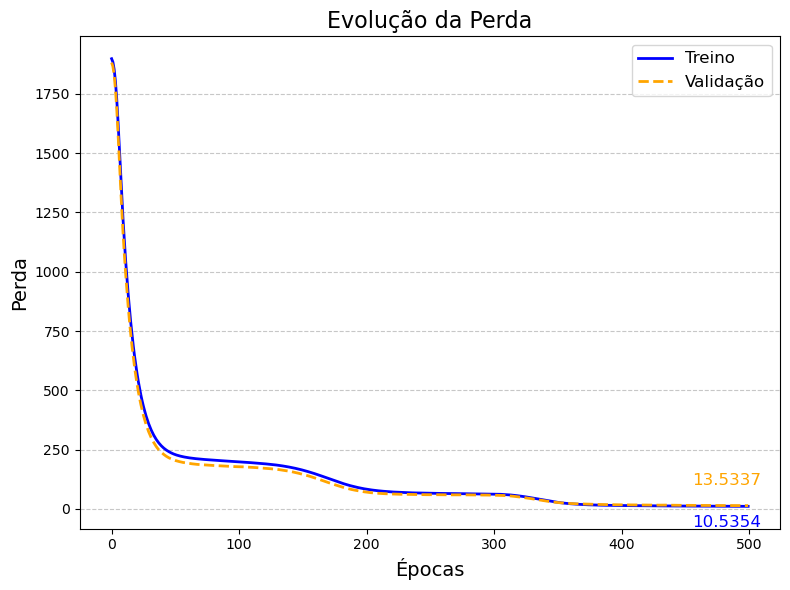

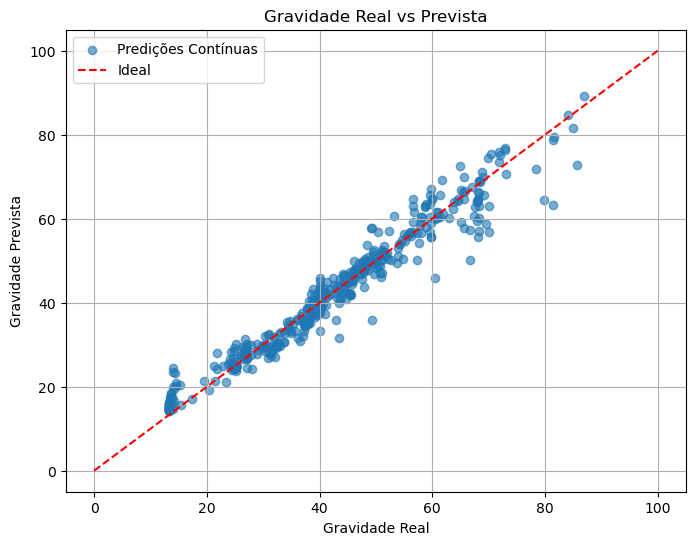

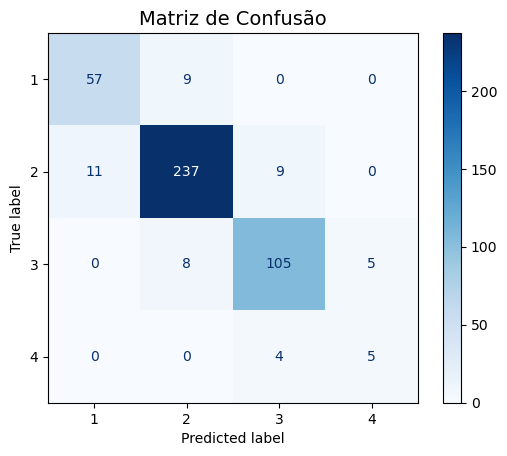

In [1039]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Função para suavizar curvas com médias móveis
def smooth_curve(values, weight=0.90):
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = last * weight + (1 - weight) * v
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

# Gráfico de Perda
plt.figure(figsize=(8, 6))
train_loss = smooth_curve(history.history["loss"])
val_loss = smooth_curve(history.history["val_loss"])
plt.plot(train_loss, label="Treino", linewidth=2, color="blue")
plt.plot(val_loss, label="Validação", linewidth=2, linestyle="--", color="orange")
plt.title("Evolução da Perda", fontsize=16)
plt.xlabel("Épocas", fontsize=14)
plt.ylabel("Perda", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adicionar anotação dos valores finais
plt.annotate(
    f"{train_loss[-1]:.4f}",
    xy=(len(train_loss) - 1, train_loss[-1]),
    xytext=(-40, -15),
    textcoords="offset points",
    fontsize=12,
    color="blue",
)
plt.annotate(
    f"{val_loss[-1]:.4f}",
    xy=(len(val_loss) - 1, val_loss[-1]),
    xytext=(-40, 15),
    textcoords="offset points",
    fontsize=12,
    color="orange",
)

plt.tight_layout()
plt.show()



plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_continuous, alpha=0.6, label="Predições Contínuas")
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label="Ideal")
plt.xlabel("Gravidade Real")
plt.ylabel("Gravidade Prevista")
plt.title("Gravidade Real vs Prevista")
plt.legend()
plt.grid()
plt.show()

# Calcular a matriz de confusão
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Exibir a matriz de confusão com o display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4])

# Plotar a matriz de confusão
disp.plot(cmap="Blues", values_format="d")

# Título e exibição
plt.title("Matriz de Confusão", fontsize=14)
plt.show()
